In [1]:
# ToS: A tool to analyze Terms of Service.
# Copyright (C) 2024 José María Cruz Lorite
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.

In this network we explore the distinct types of sections normally found in online Term of Service documents.

To achive that we use an small set of documents (the tos30 dataset) and use (1) docling to extract the headings (sections) and (2) BERT to cluster them. With this informations we infer the general type of sections.

### Download all ToS documents and get headings

In [25]:
from tos.utils import load_dataset_tos30
from tos.readers import TosHierarchicalReader

urls = load_dataset_tos30()
reader = TosHierarchicalReader()

corpus = set()
docs = []
for url in urls:
    tos = reader.read_url(url)
    for term in tos.terms:
        corpus.add(term.meta.headings[-1] if term.meta.headings else None)
    docs.append(tos)
corpus = list(corpus)

--- Logging error ---
Traceback (most recent call last):
  File "/home/jmcruz/anaconda3/envs/tos_crawler/lib/python3.11/site-packages/docling/backend/html_backend.py", line 96, in walk
    self.analyse_element(element, idx, doc)
  File "/home/jmcruz/anaconda3/envs/tos_crawler/lib/python3.11/site-packages/docling/backend/html_backend.py", line 126, in analyse_element
    self.handle_listitem(element, idx, doc)
  File "/home/jmcruz/anaconda3/envs/tos_crawler/lib/python3.11/site-packages/docling/backend/html_backend.py", line 244, in handle_listitem
    parent_list_label = self.parents[self.level].label
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'label'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jmcruz/anaconda3/envs/tos_crawler/lib/python3.11/logging/__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "/

In [26]:
corpus

['',
 '2. RIGHTS AND LIMITATIONS ON USE',
 'Indemnity',
 'Get involved',
 'Our Rights',
 'Payment, Refunds, Upgrading and Downgrading Terms',
 'D. User-Generated Content',
 'Contact Information',
 '3. How We May Use Your Personal Information',
 'Try Slack with your team for free',
 'Subscribe to our blog',
 '9. MARKETING',
 'SECTION 6 – REFUNDS',
 'E. Private Repositories',
 'Widgets',
 '25.3 BOX AI',
 'General Terms of Use',
 'Stay informed',
 'Materials',
 '7. CHANGES TO THIS AGREEMENT',
 'N. Disclaimer of Warranties',
 '28.8 Personal Data of Children.',
 'IV. Rules and abuse',
 'Log Data',
 '5. Provision of API',
 'Limitation of Liability; Waiver',
 'Resolution of EU-US Data Privacy Framework queries and complaint mechanism',
 'Business Transfers',
 'Overleaf AI',
 'O. Limitation of Liability',
 'SECTION 13 – COMPLIANCE WITH THE LAWS',
 'Global',
 '14. General Terms',
 '5. APP ACCESS AND USE',
 'Current Terms of Use',
 '10. USE RESTRICTIONS; RESPONSIBILITY FOR USE',
 'GDPR',
 'SECTI

### Load model

In [27]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("google-bert/bert-base-uncased")

No sentence-transformers model found with name google-bert/bert-base-uncased. Creating a new one with mean pooling.


### Generate embeddings

In [28]:
embeddings = model.encode(corpus)
embeddings.shape

(629, 768)

### Clustering embeddings

In [35]:
import pandas as pd
from sklearn.cluster import KMeans

K = 5
kmeans = KMeans(random_state=0).fit(embeddings)
cls_dist=pd.Series(kmeans.labels_).value_counts()

In [36]:
cls_dist

1    103
2     97
5     96
7     93
6     80
4     67
0     50
3     43
Name: count, dtype: int64

### Finding one real sentence embedding, closest to each centroid point

In [37]:
import numpy as np
import scipy

distances = scipy.spatial.distance.cdist(kmeans.cluster_centers_, embeddings)
centers={}
print("Cluster", "Size", "Center-idx","Center-Example", sep="\t\t")
for i,d in enumerate(distances):
    ind = np.argsort(d, axis=0)[0]
    centers[i]=ind
    print(i,cls_dist[i], ind, corpus[ind] ,sep="\t\t")

Cluster		Size		Center-idx		Center-Example
0		50		42		7. LIMITATION OF LIABILITY
1		103		291		Overview
2		97		105		3. Billing Schedule; No Refunds
3		43		595		Archived Terms of Use
4		67		522		5. How We Protect Your Personal Information
5		96		71		4. Authorization
6		80		161		5. Using Canva to Publish a Website
7		93		103		SECTION 8 – SUBSCRIPTION TERMS AND AUTOMATIC PAYMENT


### Plotting the Kmeans clusters after reducing dimensionality

[1 0 0 1 7 2 3 3 4 6 3 5 7 4 6 6 7 1 1 2 0 2 2 1 2 0 4 1 6 0 7 1 5 6 3 2 1
 2 7 5 4 1 0 4 6 2 1 6 5 1 4 5 4 4 0 5 4 5 0 1 5 6 1 1 1 5 0 6 2 6 7 5 2 1
 6 1 1 3 1 7 2 6 2 4 6 7 1 5 2 2 2 0 2 6 2 2 7 3 2 5 1 5 1 7 0 2 3 2 1 2 7
 5 6 7 3 5 5 4 7 5 6 2 4 3 0 1 1 2 4 3 3 1 3 7 6 2 7 7 0 2 3 3 7 0 1 1 6 2
 3 6 7 5 5 3 2 1 2 3 1 1 7 6 1 6 6 2 7 3 7 5 3 5 1 0 6 5 0 6 4 1 1 1 1 7 7
 5 5 3 2 7 0 1 6 1 5 1 4 7 7 0 6 3 2 2 2 5 7 1 1 6 1 5 0 0 7 3 0 6 1 7 2 6
 1 2 2 4 0 1 3 6 5 1 5 4 7 2 5 5 7 4 7 2 7 2 2 5 2 2 5 1 7 0 2 2 2 4 2 4 7
 5 4 4 5 0 0 1 4 3 5 1 5 4 2 6 1 5 2 2 6 1 5 5 5 5 7 1 2 3 6 6 1 1 4 6 0 2
 7 1 1 4 2 5 1 6 6 6 2 6 4 7 5 5 1 4 5 6 7 7 6 3 1 1 2 5 2 5 7 5 4 5 7 7 7
 5 5 7 4 7 2 2 5 4 4 6 2 0 6 7 3 5 5 1 7 7 1 1 7 1 7 7 4 4 1 7 7 2 1 2 1 4
 5 7 7 7 7 4 1 1 7 4 4 7 6 2 0 1 5 6 4 3 0 4 1 0 1 6 1 4 0 2 1 1 0 0 5 6 1
 4 0 7 1 0 2 7 7 7 7 5 7 4 0 4 7 5 6 4 2 2 7 5 0 6 5 7 2 3 1 5 1 1 5 6 1 2
 6 4 7 5 5 6 0 5 1 4 4 4 7 3 3 0 0 2 4 0 6 2 4 0 1 2 7 4 0 6 4 6 4 2 5 6 5
 7 4 7 2 7 2 0 5 3 7 6 0 

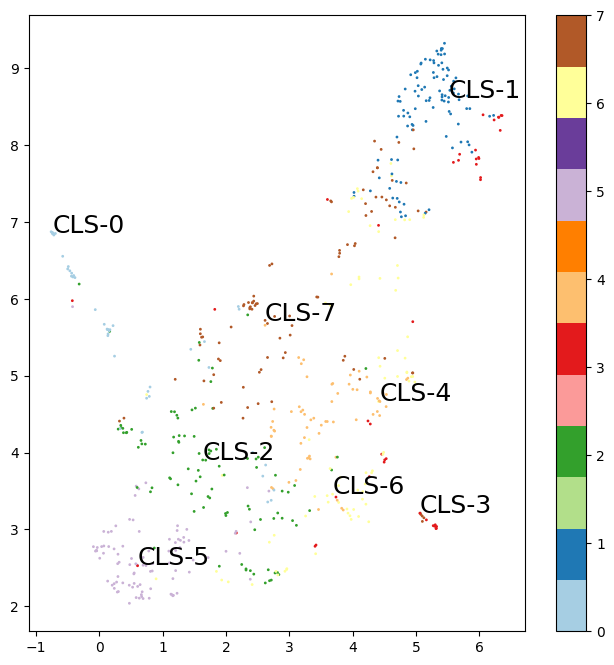

In [57]:
import matplotlib.pyplot as plt
import umap

X = umap.UMAP(n_components=2,min_dist=0.0).fit_transform(embeddings)
labels= kmeans.labels_
print(labels)
fig, ax = plt.subplots(figsize=(8,8))
print(X[:,0])
plt.scatter(X[:,0], X[:,1], c=labels, s=1, cmap='Paired')
for c in centers:
    plt.text(X[centers[c],0], X[centers[c], 1],"CLS-"+ str(c), fontsize=18)
plt.colorbar()

Based on the themes of each cluster, here are descriptive names for each:

Cluster 0: Liability, Warranty, and Indemnification\
Cluster 1: General Information, Policies, and User Resources\
Cluster 2: Payments, Terms Modifications, and Compliance\
Cluster 3: User Accounts, Content, and Third-Party Services\
Cluster 4: Privacy, Data Use, and Intellectual Property\
Cluster 5: Account Security, Confidentiality, and Legal Obligations\
Cluster 6: App Integrations, User Engagement, and Platform Features\
Cluster 7: Legal and Regulatory Compliance, User Rights, and Dispute Resolution

### Overleaf analysis

| URL                                  | Document Name             | Section                                    | Topic                                                |
|--------------------------------------|---------------------------|--------------------------------------------|------------------------------------------------------|
| https://www.overleaf.com/legal#Terms | Overleaf Terms of Service | Your Stuff & Your Privacy                  | Privacy, Data Use, and Intellectual Property         |
| https://www.overleaf.com/legal#Terms | Overleaf Terms of Service | Sharing Your Stuff                         | Privacy, Data Use, and Intellectual Property         |
| https://www.overleaf.com/legal#Terms | Overleaf Terms of Service | Registering with us                        | General Information, Policies, and User Resources    |
| https://www.overleaf.com/legal#Terms | Overleaf Terms of Service | Managed Accounts                           | General Information, Policies, and User Resources    |
| https://www.overleaf.com/legal#Terms | Overleaf Terms of Service | Overleaf AI                                | App Integrations, User Engagement, and Platform Features |
| https://www.overleaf.com/legal#Terms | Overleaf Terms of Service | Our Rights                                 | Liability, Warranty, and Indemnification             |
| https://www.overleaf.com/legal#Terms | Overleaf Terms of Service | Your Responsibilities                      | General Information, Policies, and User Resources    |
| https://www.overleaf.com/legal#Terms | Overleaf Terms of Service | Beta Services                              | App Integrations, User Engagement, and Platform Features |
| https://www.overleaf.com/legal#Terms | Overleaf Terms of Service | Your Feedback                              | General Information, Policies, and User Resources    |
| https://www.overleaf.com/legal#Terms | Overleaf Terms of Service | Acceptable Use Policy                      | Legal and Regulatory Compliance, User Rights, and Dispute Resolution |
| https://www.overleaf.com/legal#Terms | Overleaf Terms of Service | Links to or from the Service               | App Integrations, User Engagement, and Platform Features |
| https://www.overleaf.com/legal#Terms | Overleaf Terms of Service | Order Process and Formation of a Contract  | Payments, Terms Modifications, and Compliance        |
| https://www.overleaf.com/legal#Terms | Overleaf Terms of Service | Prices, Payments, Tax and Refunds          | Payments, Terms Modifications, and Compliance        |
| https://www.overleaf.com/legal#Terms | Overleaf Terms of Service | Termination                                | General Information, Policies, and User Resources    |
| https://www.overleaf.com/legal#Terms | Overleaf Terms of Service | Use post-termination                       | Liability, Warranty, and Indemnification             |
| https://www.overleaf.com/legal#Terms | Overleaf Terms of Service | Overleaf is provided “AS-IS”               | Liability, Warranty, and Indemnification             |
| https://www.overleaf.com/legal#Terms | Overleaf Terms of Service | Limitation of Liability                    | Liability, Warranty, and Indemnification             |
| https://www.overleaf.com/legal#Terms | Overleaf Terms of Service | Separate Contract and Additional Terms     | Payments, Terms Modifications, and Compliance        |
| https://www.overleaf.com/legal#Terms | Overleaf Terms of Service | Change to these Terms                      | Payments, Terms Modifications, and Compliance        |
| https://www.overleaf.com/legal#Terms | Overleaf Terms of Service | US Government Users                        | Legal and Regulatory Compliance, User Rights, and Dispute Resolution |
| https://www.overleaf.com/legal#Terms | Overleaf Terms of Service | Miscellaneous Legal Terms                  | Legal and Regulatory Compliance, User Rights, and Dispute Resolution |
| https://www.overleaf.com/legal#Terms | Overleaf Terms of Service | Force Majeure                              | Legal and Regulatory Compliance, User Rights, and Dispute Resolution |
| https://www.overleaf.com/legal#Terms | Overleaf Terms of Service | Notices                                    | Legal and Regulatory Compliance, User Rights, and Dispute Resolution |
| https://www.overleaf.com/legal#Terms | Overleaf Terms of Service | Digital Science UK Limited Company Details | General Information, Policies, and User Resources    |
